In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

below cell prevents the error 'OSError: image file is truncated (2 bytes not processed)'

[fastai forum](https://forums.fast.ai/t/oserror-image-file-is-truncated-18-bytes-not-processed/52913)

In [15]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [16]:
from fastai.vision import *
from fastai.metrics import error_rate

Batch size and path settings

NOTE: In order to use ImageDataBunch, the folders training_set and testing_set have to be renamed to train and test respectively

Alternatively, set the path values as shown in [documentation](https://docs.fast.ai/vision.data.html#ImageDataBunch.from_folder)

In [17]:
bs = 64
data_path='data/face-shape-dataset'

In [24]:
data = ImageDataBunch.from_folder(data_path, train='training_set', valid='testing_set', ds_tfms=get_transforms(), size=224, bs=bs).normalize(imagenet_stats)

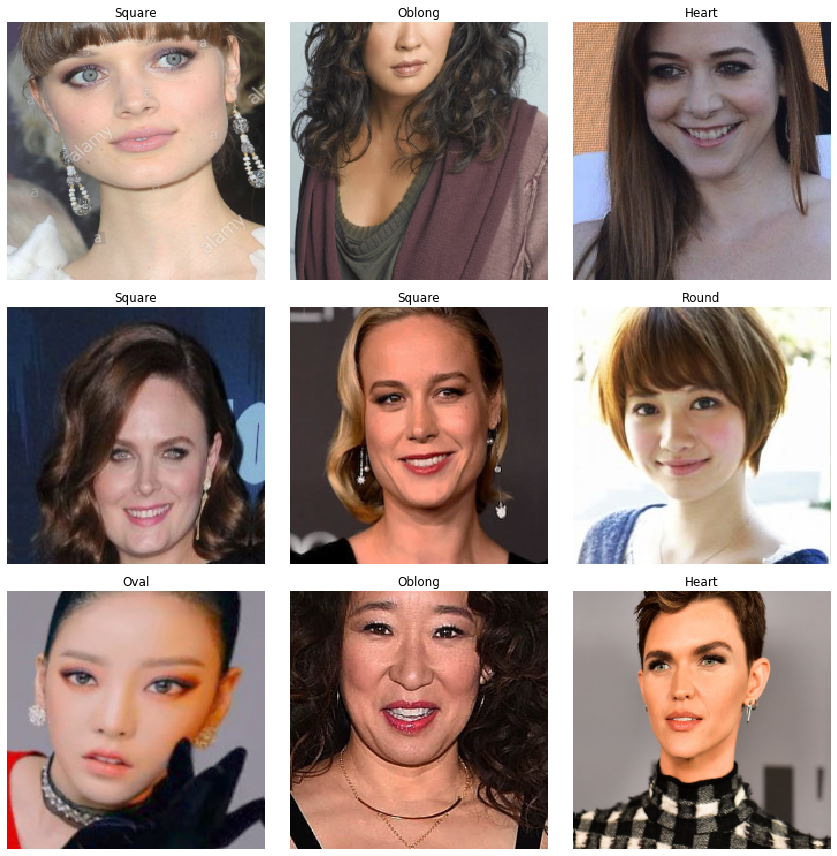

In [25]:
data.show_batch(rows=3, figsize=(12,12))

In [26]:
print(data.classes)

['Heart', 'Oblong', 'Oval', 'Round', 'Square']


In [27]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [28]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [29]:
learn.fit_one_cycle(4)

In [30]:
learn.save('stage-1')

# Results

Let's see what results we have got.

We will first see which were the categories that the model most confused with one another. We will try to see if what the model predicted was reasonable or not. In this case the mistakes look reasonable (none of the mistakes seems obviously naive). This is an indicator that our classifier is working correctly.

Furthermore, when we plot the confusion matrix, we can see that the distribution is heavily skewed: the model makes the same mistakes over and over again but it rarely confuses other categories. This suggests that it just finds it difficult to distinguish some specific categories between each other; this is normal behaviour.

In [31]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

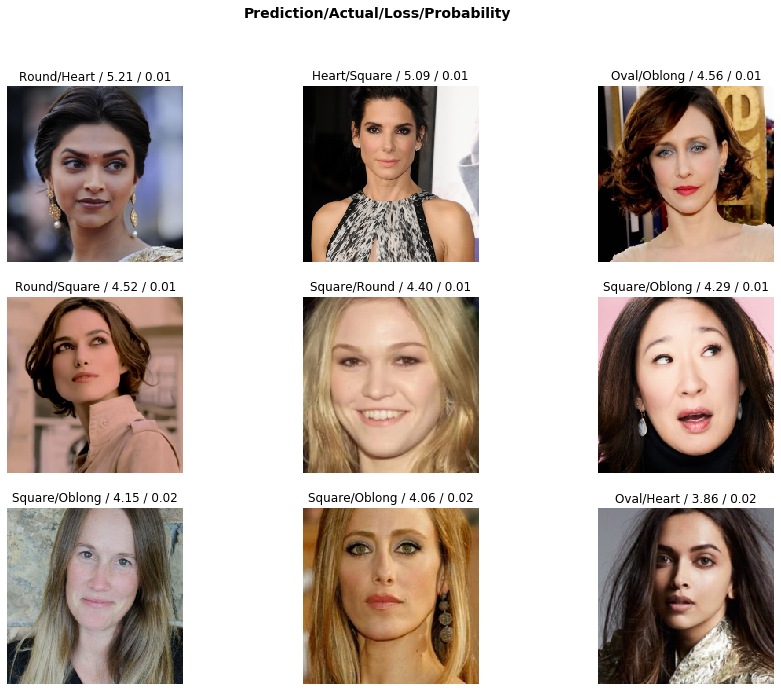

In [32]:
interp.plot_top_losses(9, figsize=(15,11))

In [34]:
# check the documetation for interp.plot_top_losses
doc(interp.plot_top_losses)

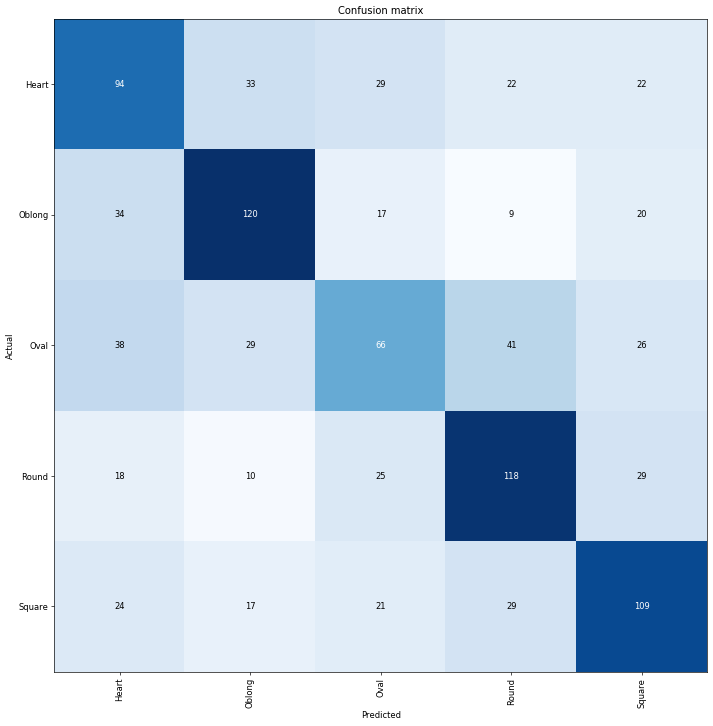

In [35]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [36]:
interp.most_confused(min_val=2)

[('Oval', 'Round', 41),
 ('Oval', 'Heart', 38),
 ('Oblong', 'Heart', 34),
 ('Heart', 'Oblong', 33),
 ('Heart', 'Oval', 29),
 ('Oval', 'Oblong', 29),
 ('Round', 'Square', 29),
 ('Square', 'Round', 29),
 ('Oval', 'Square', 26),
 ('Round', 'Oval', 25),
 ('Square', 'Heart', 24),
 ('Heart', 'Round', 22),
 ('Heart', 'Square', 22),
 ('Square', 'Oval', 21),
 ('Oblong', 'Square', 20),
 ('Round', 'Heart', 18),
 ('Oblong', 'Oval', 17),
 ('Square', 'Oblong', 17),
 ('Round', 'Oblong', 10),
 ('Oblong', 'Round', 9)]

# Unfreezing, fine-tuning, and learning rates

Since our model is working as we expect it to, we will unfreeze our model and train some more.

In [37]:
learn.unfreeze()

In [38]:
learn.fit_one_cycle(1)

In [39]:
learn.load('stage-1');

In [40]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


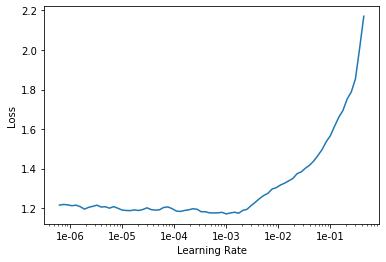

In [41]:
learn.recorder.plot()

In [43]:
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-3))

In [44]:
learn.save('stage-1')

# Improvements

The error rate dropped from 0.493 to 0.275. Let's check the confusion matrix

In [45]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

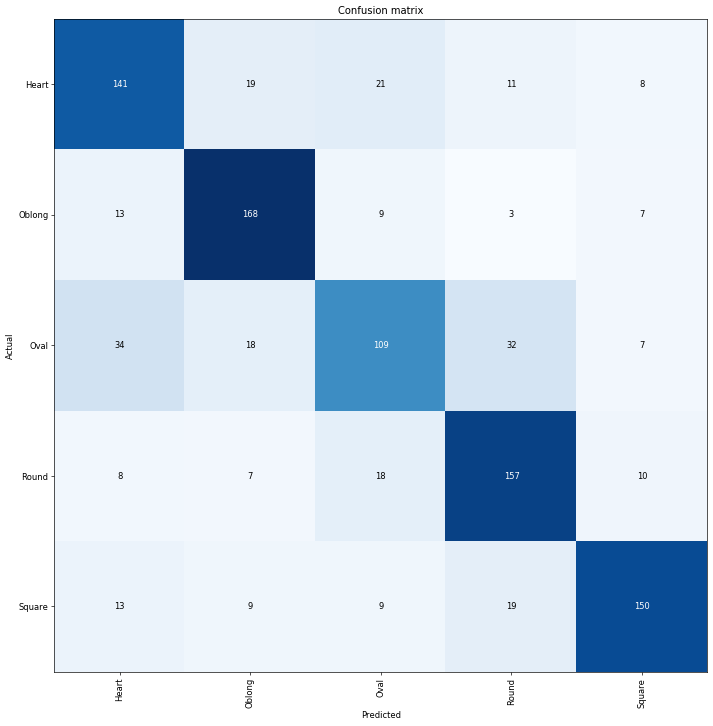

In [46]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

# Heatmaps
## Where is the neural network looking for clues

Category Oblong

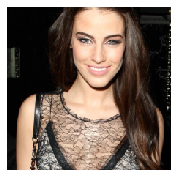

In [70]:
idx=0
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [71]:
m = learn.model.eval();

In [72]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [73]:
from fastai.callbacks.hooks import *

In [74]:
def hooked_backward(cat=y):
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

In [75]:
hook_a,hook_g = hooked_backward()

In [76]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 7, 7])

In [77]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([7, 7])

In [78]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,224,224,0),
              interpolation='bilinear', cmap='magma');

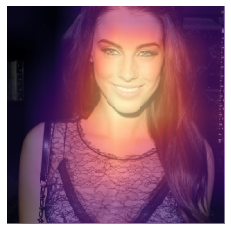

In [79]:
show_heatmap(avg_acts)

## Grad-CAM¶
Paper: [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391)

In [80]:
grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

(torch.Size([512, 7, 7]), torch.Size([512]))

In [81]:
mult = (acts*grad_chan[...,None,None]).mean(0)

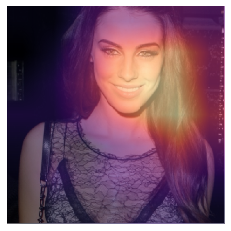

In [82]:
show_heatmap(mult)

In [89]:
fn = '/home/niko/Pictures/niko-cropped-face.jpg'

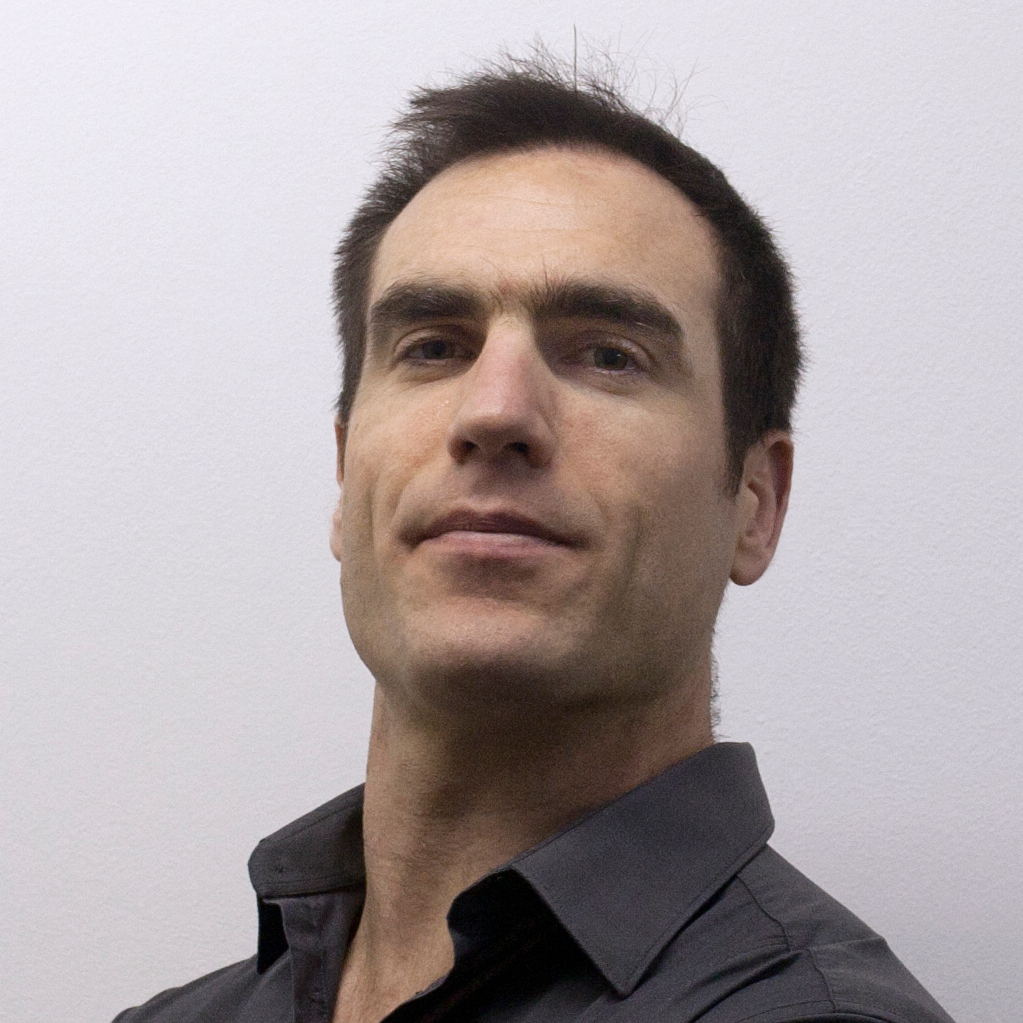

In [90]:
x = open_image(fn); x

In [91]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [92]:
hook_a,hook_g = hooked_backward()

In [93]:
acts = hook_a.stored[0].cpu()
grad = hook_g.stored[0][0].cpu()

grad_chan = grad.mean(1).mean(1)
mult = (acts*grad_chan[...,None,None]).mean(0)

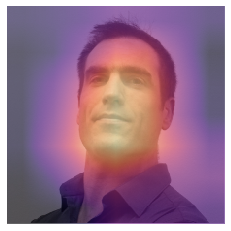

In [94]:
show_heatmap(mult)